<a href="https://colab.research.google.com/github/Rafinze/NeuralNetworkProjects/blob/main/Projeto_2_Modelo_N%C3%A3o_Supervisionado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Modelo Não-Supervisionado
*Rafael Pires Moreira Silva - 163978*

*Instruções:*

1) Selecionar pelo menos dois datasets:

2) Aplicar um modelo neural não supervisionado (SOM, GNG, etc.)

3) Avaliar os padrões detectados em cada conjunto:
- Clusters / outliers, etc.
  
- Avaliar a homogeneidade dos agrupamentos

4) Variar os parâmetros do modelo (grid, taxas, número de neurônios, etc.)



Primeiramente, vamos realizar a importação das bibliotecas que serão utilizadas ao longo do projeto.

In [ ]:
!pip install minisom
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.datasets import make_moons, fetch_olivetti_faces
from sklearn.preprocessing import MinMaxScaler

from minisom import MiniSom

## Análise em Dados Sintéticos: `make_moons`

Para uma primeira avaliação do SOM, utilizamos o conjunto de dados `make_moons`. Ele gera duas luas entrelaçadas, um padrão que é simples de visualizar, mas que não é linearmente separável. Com isso, verificaremos sse o SOM consegue mapear e agurpar corretamente essa estrutura.

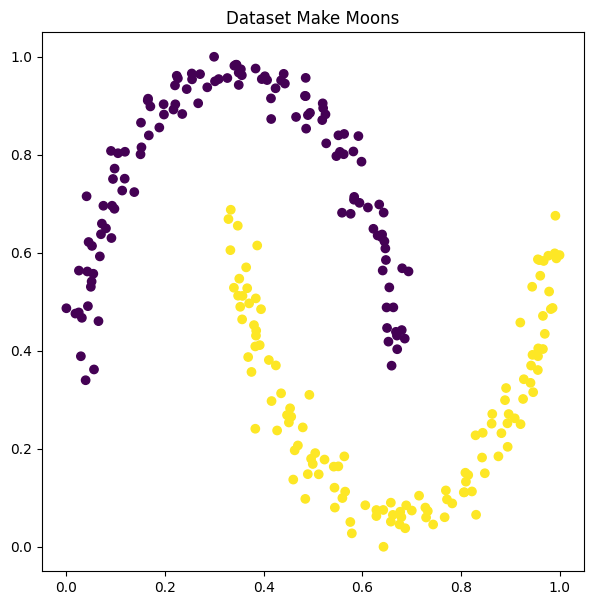

In [ ]:
X, y = make_moons(n_samples=250, noise=0.05, random_state=0)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.title('Dataset Make Moons')
plt.show()

##  Treinamento do SOM (make_moons)

Inicializamos e treinamos o SOM com os dados `make_moons`. A rede é configurada como um mapa de 15x15 neurônios.

In [ ]:
map_size_x = 15
map_size_y = 15

som = MiniSom(map_size_x, map_size_y, input_len=X.shape[1],
              sigma=1.5, learning_rate=0.5,
              neighborhood_function='gaussian', random_seed=42)

som.train_random(X, 500, verbose=True)

 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 0.02424154494931762


##  Visualização e Análise dos Resultados

Após o treinamento, desenhamos as fronteiras entre os grupo de dados, com a indicação de quais dados pertencem a cada um desses gurpos para a vlaidação.


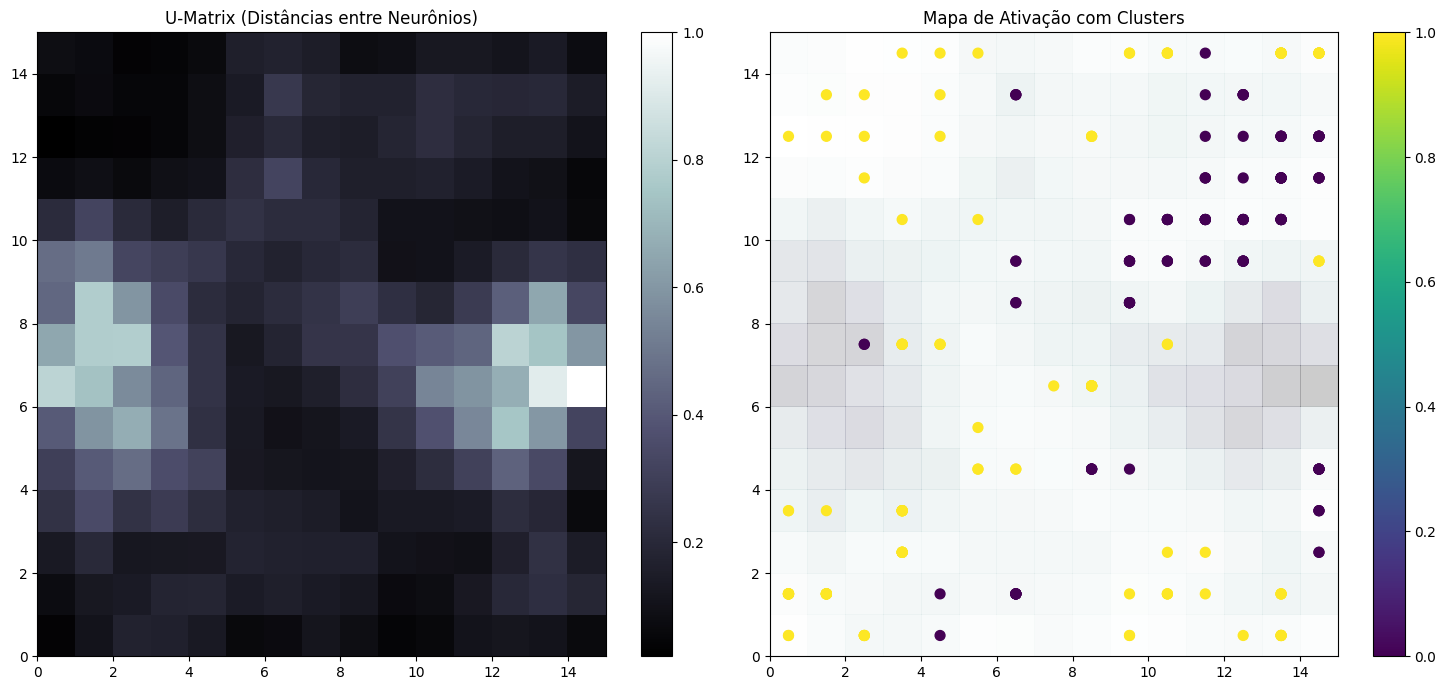

In [ ]:
winner_coordinates = np.array([som.winner(x) for x in X]).T
cluster_index = np.ravel_multi_index(winner_coordinates, (map_size_x, map_size_y))

plt.figure(figsize=(15, 7))
gs = GridSpec(1, 2)

ax1 = plt.subplot(gs[0, 0])
plt.bone()
plt.pcolor(som.distance_map().T)
plt.colorbar()
plt.title('U-Matrix (Distâncias entre Neurônios)')

ax2 = plt.subplot(gs[0, 1])
plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=0.2)
plt.scatter(winner_coordinates[0] + .5, winner_coordinates[1] + .5, c=y, s=50, cmap='viridis')
plt.colorbar()
plt.title('Mapa de Ativação com Clusters')

plt.tight_layout()
plt.show()

##  Análise em Dados de Alta Dimensão: `Olivetti Faces`

Com isso, passamos para um próximo dataset, o `Olivetti Faces`. Este conjunto de dados contém 400 imagens de faces (64x64 pixels), resultando em 4096 dimensoes por amstra. O objetivo aqui é ver se o SOM consegue organizar as imagens de forma coerente, agrupando faces similares por características como pose, expressão ou identidade da pessoa.

In [ ]:
faces = fetch_olivetti_faces()
X_faces = faces.data
y_faces = faces.target

print("Dimensao dos dados das faces:", X_faces.shape)

Dimensao dos dados das faces: (400, 4096)


##  Treinamento do SOM (Olivetti Faces)

Para este novo dataset, aumentamos o tamanho do mapa para 20x20, para guardar dados com maior variabilidade. O processo de treinamento será o mesmo, alterando apenas a dimensionalidade dos dados.

In [ ]:
map_size_x_faces = 20
map_size_y_faces = 20

som_faces = MiniSom(map_size_x_faces, map_size_y_faces, input_len=X_faces.shape[1],
                    sigma=3.0, learning_rate=0.7,
                    neighborhood_function='gaussian', random_seed=42)

som_faces.train_random(X_faces, 2000, verbose=True)

 [ 2000 / 2000 ] 100% - 0:00:00 left 
 quantization error: 4.617909333847255


## Mapeamento das Faces na Rede

A visualização mais eficiente do SOM em dados de imagem é projetar as próprias imagens de volta no mapa. Assim, para cada neurônio , encontramos a imagem que mais o ativou (seu BMU) e a exibimos em sua posição correspondente. O resultado é um mapa de faces que organiza visualmente todo o dataset, que possibilida uma visualizaçao mais intuitiva .

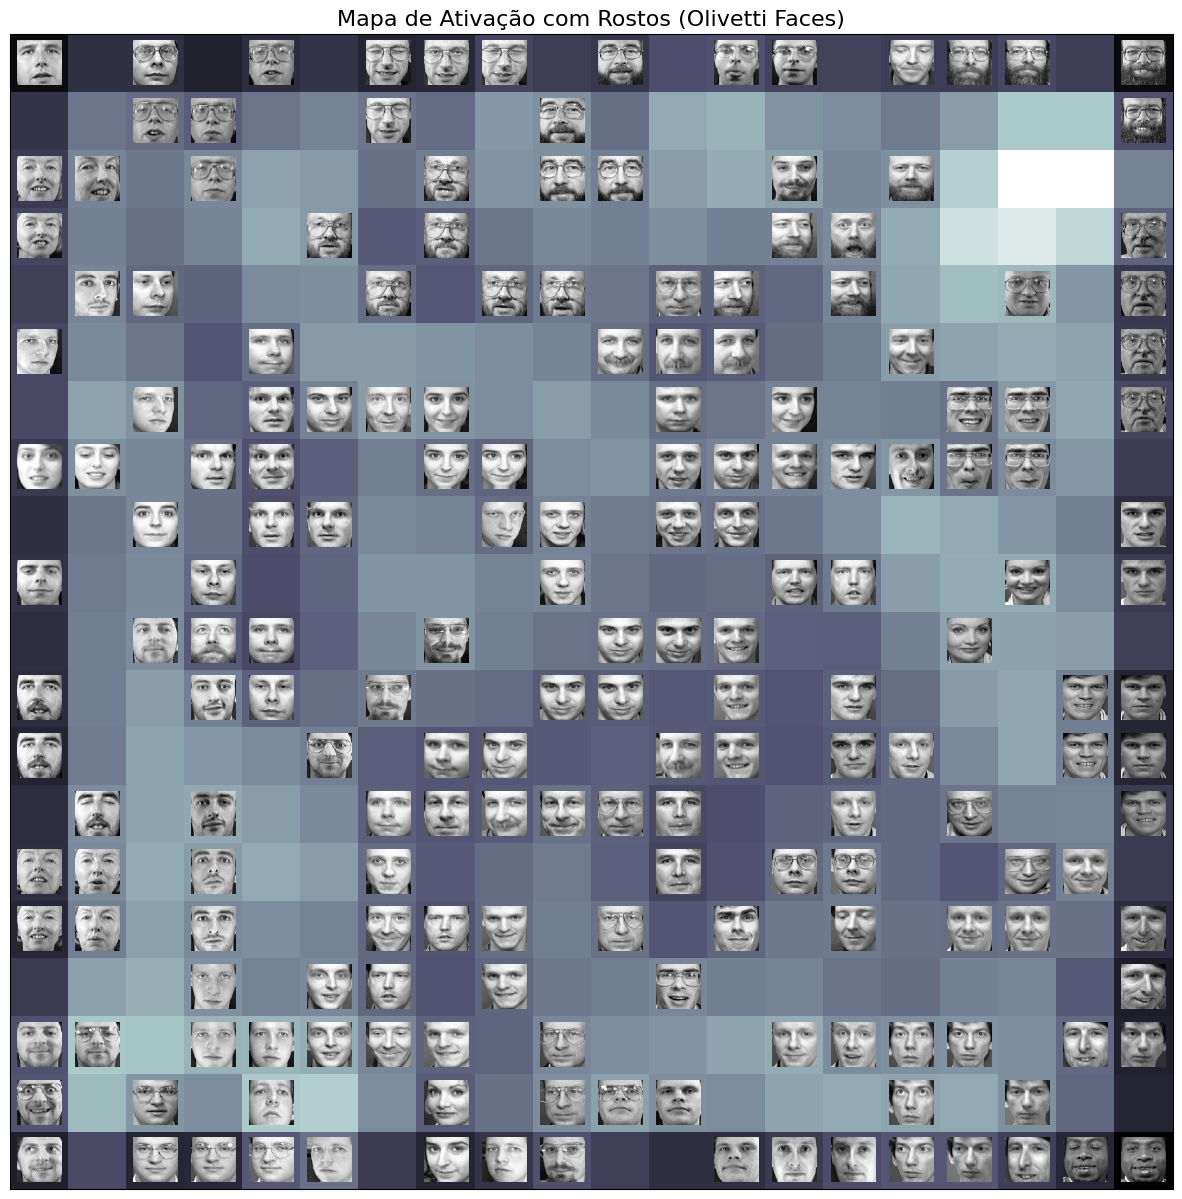

In [ ]:
face_colors = plt.cm.jet(np.linspace(0, 1, 40))

fig, ax = plt.subplots(figsize=(15, 15))
ax.set_title('Mapa de Ativação com Rostos (Olivetti Faces)', fontsize=16)
bone()
ax.pcolor(som_faces.distance_map().T)

annotated_neurons = set()

for i, x_scaled in enumerate(X_faces_scaled):
    w = som_faces.winner(x_scaled)

    ax.plot(w[0] + 0.5, w[1] + 0.5, 'o', markerfacecolor='None',
            markeredgecolor=face_colors[y_faces[i]], markersize=14, markeredgewidth=2)


    if w not in annotated_neurons:
      face_image = X_faces[i].reshape(64, 64)
      img_box = OffsetImage(face_image, cmap='gray', zoom=0.5)
      ab = AnnotationBbox(img_box, (w[0] + 0.5, w[1] + 0.5),
                          xycoords='data', frameon=False, pad=0.0)
      ax.add_artist(ab)
      annotated_neurons.add(w)

ax.set_xticks([])
ax.set_yticks([])
plt.show()

## Análise do Erro de Quantização

 Um erro de quantização alto para uma amostra específica indica que ela é um outlier ou uma anomalia, pois não se encaixa bem em nenhum dos clusters formados pela rede. Calculamos e visualizamos esse erro para cada imagem.

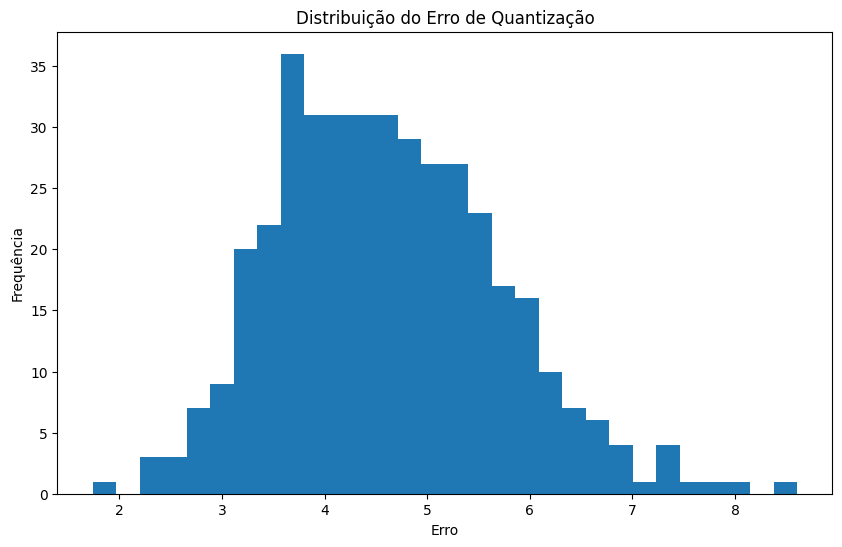

Índice da imagem com maior erro: 354


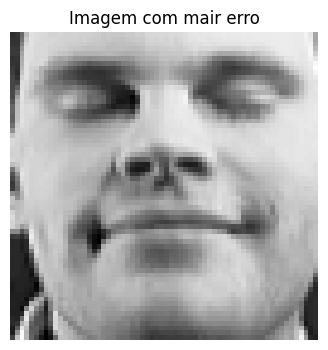

In [ ]:
q_error = []
for x in X_faces:
    q_error.append(som_faces.quantization_error([x]))

plt.figure(figsize=(10, 6))
plt.hist(q_error, bins=30)
plt.title('Distribuição do erro de quantização')
plt.xlabel('Erro')
plt.ylabel('Frequência')
plt.show()

idx_max_error = np.argmax(q_error)
print(f"Índice da imagem com maior erro: {idx_max_error}")

plt.figure(figsize=(4, 4))
plt.title(f'Imagem com mair erro')
plt.imshow(np.reshape(X_faces[idx_max_error], (64, 64)), cmap='gray')
plt.axis('off')
plt.show()

## Análise Quantitativa da Homogeneidade dos Clusters

Além da análise visual, é importante medir quantitativamente a qualidade dos agrupamentos formados. Utilizando a Homogeneity Score, conseguimos ver se cada cluster gerado pelo SOM contém apenas amostras de uma única classe original. Onde 1 indica um score totalmente homogêneo

Assim, conseguimos ver quão bem o mapa conseguiu separar as classes distintas presentes em cada dataset.

In [ ]:
from sklearn.metrics import homogeneity_score

winner_coords_moons = np.array([som.winner(x) for x in X]).T
cluster_labels_moons = np.ravel_multi_index(winner_coords_moons, (map_size_x, map_size_y))
homogeneity_moons = homogeneity_score(y, cluster_labels_moons)
print(f"Score de Homogeneidade (Make Moons): {homogeneity_moons:.4f}")

winner_coords_faces = np.array([som_faces.winner(x) for x in X_faces]).T
cluster_labels_faces = np.ravel_multi_index(winner_coords_faces, (map_size_x_faces, map_size_y_faces))
homogeneity_faces = homogeneity_score(y_faces, cluster_labels_faces)
print(f"Score de Homogeneidade (Olivetti Faces): {homogeneity_faces:.4f}")

COm os resultados obtidos fica evidente a capacidade e a versatilidade da rede SOM como uma ferramenta eficiente de análise exploratória. Os resultados nos mostraram  que a rede dominou a complexidade dos dados, tendo sido capaz de modelar com sucesso tanto a estrutura não-linear do dataset `make_moons` quanto o espaço de alta dimensão das imagens do `Olivetti Faces`.
Além disso, sua função fez mais que um simples agrupamento, revelando-se uma técnica de mapeamento que preserva a topologia dos dados. A organização visual do mapa de faces é uma prova clara de sua habilidade em criar uma representação intuitiva da similaridade, algo que métodos de clustering tradicionais não oferecem.

Além disso, vimos que a rede SOM é uma boa alternativa para visualizar dados de datasets complexos, pois é de simples implementação realizar a tresnformação dde dados brutos em informações de fácil visualisação.